# Modelos Computacionales II - Proyecto Final

### Aitana Orduña Lugo

El proyecto debe desarrollar las habilidades aprendidas a lo largo del semestre:

* Análisis de dataset (AED)
* Identificación del tipo de problema (clasificación o regresión)
* Creación de propuestas de modelos (qué modelo supervisados utilizar, cómo crear la ANN o CNN a utilizar)
* Evaluación de resultados acorde al problema (clasificación: accuracy, precision, recall, f1; regresión: mse, rmse, r^2, etc. )
* Análisis de resultados (determinar el mejor resultado posible y justificar por qué es el mejor resultado posible)
* El resultado debe ser interpretable

In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_path = r"C:\Users\holai\OneDrive\Escritorio\Semestre_6\MC2F\Neurociencias-2025-2\S06_proyecto\dataset\Training"
test_path= r"C:\Users\holai\OneDrive\Escritorio\Semestre_6\MC2F\Neurociencias-2025-2\S06_proyecto\dataset\Testing"

In [45]:
# Generador con data augmentation para entrenamiento, solo rescaling para test

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,          # Rota la imagen hasta ±10 grados
    width_shift_range=0.1,      # Desplaza horizontalmente hasta un 10%
    height_shift_range=0.1,     # Desplaza verticalmente hasta un 10%
    zoom_range=0.1,             # Zoom in/out hasta un 10%
    horizontal_flip=True,        # Invierte la imagen horizontalmente
    fill_mode='nearest'    # rellenar huecos
)

# Incluye data augmentation porque:
# - Aumenta artificialmente el tamaño del dataset generando imágenes ligeramente modificadas.
# - Ayuda a reducir overfitting, permitiendo que el modelo generalice mejor a datos nuevos.
# - Solo se aplica durante el entrenamiento, no durante la validación ni la prueba.

test_datagen = ImageDataGenerator(rescale=1./255)
# Aquí NO se usan augmentations porque:
# - Se evaluan al modelo en datos reales y consistentes, no en versiones alteradas.
# - Para una evaluación objetiva y repetible del rendimiento.

In [4]:
# Cargar imágenes desde carpetas
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
# Verificar las clases 
print("Clases asignadas por Keras:")
print(train_generator.class_indices)

Clases asignadas por Keras:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 1. Análisis exploratorio del dataset (AED)

In [8]:
train_labels = train_generator.classes
test_labels = test_generator.classes

class_mapping = {v: k for k, v in train_generator.class_indices.items()}

In [10]:
train_df = pd.DataFrame(train_labels, columns=['label'])
test_df = pd.DataFrame(test_labels, columns=['label'])

train_df['label'] = train_df['label'].map(class_mapping)
test_df['label'] = test_df['label'].map(class_mapping)

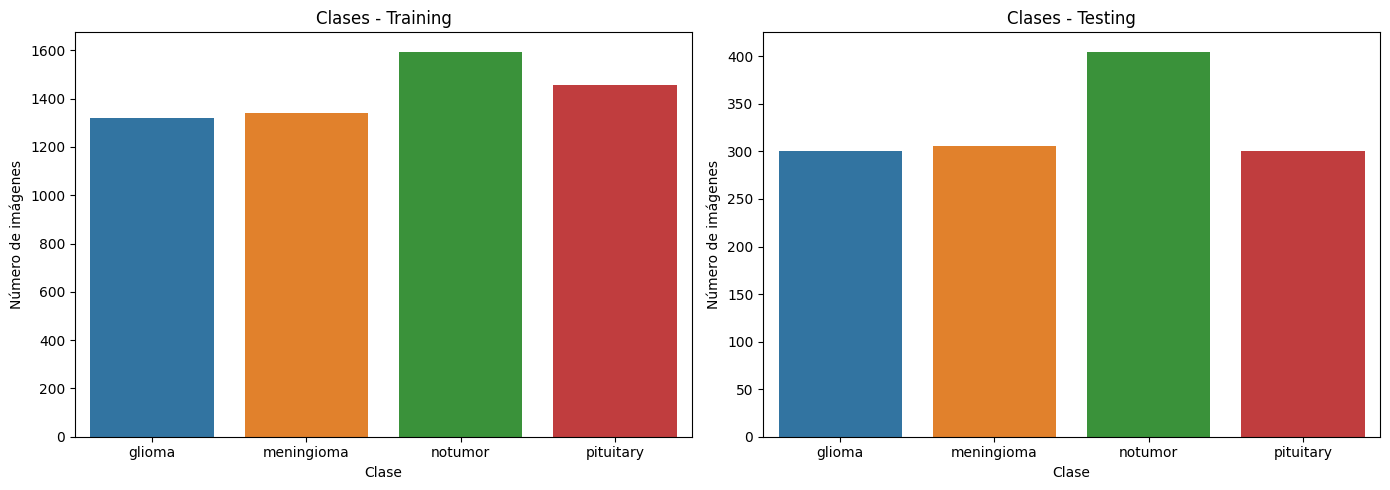

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='label', data=train_df, order=sorted(train_df['label'].unique()), ax=axs[0])
axs[0].set_title('Clases - Training')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Número de imágenes')

sns.countplot(x='label', data=test_df, order=sorted(test_df['label'].unique()), ax=axs[1])
axs[1].set_title('Clases - Testing')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Número de imágenes')

plt.tight_layout()
plt.show()

## 2. Identificación del problema (clasificación o regresión)
Considerando lo siguiente:
* El dataset tiene imágenes ya clasificadas en 4 categorías.
* No hay variables numéricas continuas como etiqueta.
* Hay más de dos clases.

Podemos decir que es un problema de **¡clasificación multiclase!**
* Ya que el objetivo de entrenar un modelo con estas imágenes es predecir una categoría discreta (en este caso el tipo de tumor) y además tenemos más de 2 clases (no es binario -> es multiclase). 

## 3. Creación de propuestas de modelos (qué modelo supervisados utilizar, cómo crear la ANN o CNN a utilizar)

Aunque podríamos utilizar modelos supervisados clásicos (extrayendo las características primero), no serían lo ideal aquí aunque podrían servir para comparar ciertas métricas como el accuracy.  
Las otras 2 opciones son las redes neuronales: artificiales o convolucionales. La mejor opción serían las CNN porque son el estándar para tareas que involucran imágenes, además tienen la capacidad de detectar patrones espaciales relevantes en las imágenes, como bordes, texturas y formas, lo cual no es posible con las ANN tradicionales.

In [34]:
# CNN desde cero !!
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(4, activation='softmax')  # porque tienes 4 clases (+ de 2)
])

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        256       
 chNormalization)                                                
                                                      

In [37]:
# Tuve que agregar esto después de correr el modelo pro primera vez porque después de ciertas epochs el accuracy 
# en training subía pero bajaba considerablemente en testing, lo cuál era señal de overfitting, 
# además de que val_loss estaba subiendo y bajando de manera muy inestable

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [38]:
# Entrenando el modelo
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20, # Pongo 20 aunque no necesariamente se cumplan
    callbacks=[early_stop]
)

Epoch 1/20
179/179 [==============================] - 181s 979ms/step - loss: 1.0654 - accuracy: 0.6183 - val_loss: 5.5389 - val_accuracy: 0.2288
Epoch 2/20
179/179 [==============================] - 165s 921ms/step - loss: 0.8346 - accuracy: 0.7068 - val_loss: 2.1382 - val_accuracy: 0.4523
Epoch 3/20
179/179 [==============================] - 161s 901ms/step - loss: 0.7667 - accuracy: 0.7360 - val_loss: 0.7374 - val_accuracy: 0.7498
Epoch 4/20
179/179 [==============================] - 164s 917ms/step - loss: 0.7078 - accuracy: 0.7581 - val_loss: 0.6817 - val_accuracy: 0.7735
Epoch 5/20
179/179 [==============================] - 162s 901ms/step - loss: 0.6541 - accuracy: 0.7791 - val_loss: 0.6056 - val_accuracy: 0.8017
Epoch 6/20
179/179 [==============================] - 165s 919ms/step - loss: 0.6185 - accuracy: 0.8008 - val_loss: 1.0841 - val_accuracy: 0.7399
Epoch 7/20
179/179 [==============================] - 177s 986ms/step - loss: 0.5879 - accuracy: 0.8127 - val_loss: 0.6035 -

In [39]:
# Aquí paró en la epoch 8 pero está tomando el valor de la 5

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy en test: {test_accuracy:.4f}")

41/41 [==============================] - 13s 317ms/step - loss: 0.6056 - accuracy: 0.8017
Accuracy en test: 0.8017


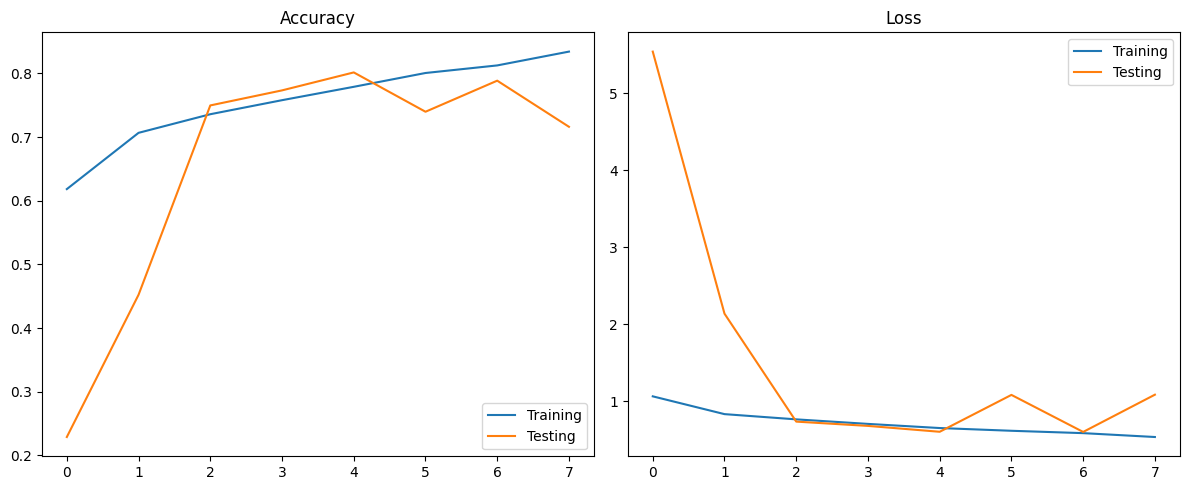

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Testing')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Testing')
plt.legend(loc='upper right')
plt.title('Loss')

plt.tight_layout()
plt.show()

## 4. Evaluación de resultados acorde al problema (clasificación: accuracy, precision, recall, f1; regresión: mse, rmse, r^2, etc. )

In [41]:
# Obtener las predicciones en formato de probabilidades
Y_pred = model.predict(test_generator)

# Convertir las probabilidades en etiquetas predichas
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 15s 355ms/step


In [42]:
# Obtener los nombres de las clases en orden correcto
class_names = list(train_generator.class_indices.keys())

# Imprimir el reporte
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.87      0.75      0.80       300
  meningioma       0.70      0.43      0.53       306
     notumor       0.77      0.99      0.87       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.80      1311
   macro avg       0.80      0.79      0.78      1311
weighted avg       0.80      0.80      0.78      1311



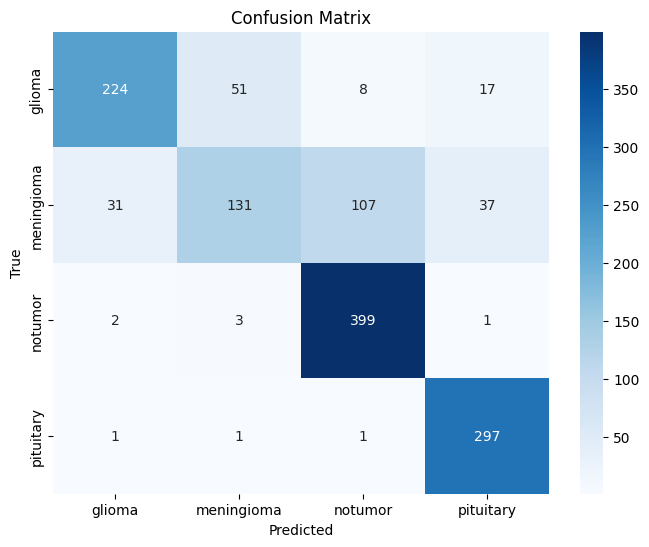

In [43]:
# Calcular la matriz de confusión
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualizarla
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5. Análisis de resultados (determinar el mejor resultado posible y justificar por qué es el mejor resultado posible)

Tuve que ajustar varias veces la CNN para poder obtener un modelo con una precisión final (accuracy) del 80.17% en el conjunto de prueba. Este valor representa una mejora considerable respecto a las primeras iteraciones, donde el accuracy rondaba el 70%.

Algunos de los cambios más relevantes que tuve que ir haciendo progresivamente son:
* Añadir capas convolucionales con filtros de 32, 64, 128 y 256 neuronas, lo cual le permitía al modelo una extracción de características más compleja.
* Normalización por lotes (Batch Normalization) después de cada capa convolucional para estabilizar y acelerar el entrenamiento.
* Dropout del 60% antes de la capa densa final, con el objetivo de forzar al modelo a generalizar mejor.
* Entrenamiento con un número alto de épocas y monitoreo del desempeño con Early Stopping para prevenir el overfitting.

En cuanto al rendimiento por clase, el modelo mostró una alta precisión y sensibilidad para las clases "notumor" y "pituitary", con un 99% de recall en ambas. La clase "glioma" también obtuvo resultados sólidos con un f1-score de 0.80. Por otro lado, la clase "meningioma" fue la de peor desempeño para el modelo, con un recall de solo 43% y una precisión del 70%. Esta diferencia sugiere que el modelo identifica algunos meningiomas correctamente, pero también comete un número significativo de falsos negativos. Esto podría deberse a una mayor similitud visual entre las imágenes de meningioma y otras clases, o bien a un desbalance de datos intra-clase, que considero la causa principal. Como se muestra en las gráficas de barras al inicio del informe, la clase "meningioma" se encuentra en desventaja en cuanto al número de imágenes disponibles en comparación con las demás.

## Conclusión

A lo largo de este proyecto, se logró desarrollar y optimizar una red neuronal convolucional (CNN) para la clasificación de imágenes de tumores cerebrales en cuatro clases: glioma, meningioma, pituitary y no tumor. 
Despues de varios ajustes al modelo se logró alcanzar un **accuracy del 80.17%** en el conjunto de prueba.
Los resultados obtenidos reflejan un buen desempeño, especialmente en la clasificación de imágenes de **"notumor"** y **"pituitary"**, ambas con un **recall del 99%**, lo cual es crucial en aplicaciones clínicas donde la sensibilidad es prioritaria. Sin embargo, la clase **"meningioma"** mostró un desempeño significativamente menor, con un recall del 43%, probablemente debido a un **desbalance de datos** y la **similitud visual con otras clases**.
En resumen, el modelo alcanzó un buen nivel de generalización y se ajustó utilizando las distintas herramientas vistas en clase. Aunque definitivamente existen áreas de mejora para el modelo, los resultados obtenidos son interpretables, sólidos y demuestran la efectividad de las CNN en tareas de clasificación médica con imágenes.

### Disclaimer: El requisito de que el resultado sea interpretable se cumple mediante la presentación de la matriz de confusión y el análisis detallado de métricas por clase en el apartado 5 (de resultados).